In [1]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from keras.utils import plot_model

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
import seaborn as sns
import pandas as pd

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 64
CLASSES = 4
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "C:/Users/REYES/OneDrive/Desktop/CNN_Projects/DATASETS/AMPALAYA_DS",
#Folder name or directory
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names

Found 2000 files belonging to 4 classes.


['Healthy',
 'Nitrogen Deficient',
 'Phosphorus Deficient',
 'Potassium Deficient']

In [4]:
# Function for augmenting images using preprocessing layers
def Crop(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image

    return image

def Rotate(image):
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image

    return image

def Contrast(image):
    image = keras.layers.RandomContrast(0.2)(image)  # Randomly adjust contrast

    return image

def Flip(image):
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image

    return image

def Brightness(image):
    image = keras.layers.RandomBrightness([0.1, 0.4])(image)  # Randomly adjust brightness

    return image

# Load and augment the training set
def get_dataset_partitions_tf(ds, train_split=0.70, val_split=0.20, test_split=0.10, shuffle=True, shuffle_size=10000, augment_data=True):
    
    # Get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting
    
    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    if augment_data:
    # Apply augmentation only to the training set
        cropped_train_ds = train_ds.map(lambda x, y: (Crop(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        rotated_train_ds = train_ds.map(lambda x, y: (Rotate(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        contrasted_train_ds = train_ds.map(lambda x, y: (Contrast(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        flipped_train_ds = train_ds.map(lambda x, y: (Flip(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        brightness_train_ds = train_ds.map(lambda x, y: (Brightness(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
    # Concatenate the original training data with the augmented data
        # train_ds = train_ds.concatenate(cropped_train_ds)
        # train_ds = train_ds.concatenate(rotated_train_ds)
        train_ds = train_ds.concatenate(contrasted_train_ds)
        # train_ds = train_ds.concatenate(flipped_train_ds)
        train_ds = train_ds.concatenate(brightness_train_ds)
    
    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
print(
    len(train_ds),
    len(val_ds),
    len(test_ds)
)

66 6 4


In [7]:
resnet_model = keras.Sequential()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', classes=4)
predictions = Dense(4, activation='softmax')

for layer in base_model.layers:
    layer.trainable = False

resnet_model.add(base_model)
resnet_model.add(layers.Flatten())

# Regularization and Dropout
resnet_model.add(layers.Dense(512, activation='relu', kernel_regularizer=L2(0.005)))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(512, activation='relu', kernel_regularizer=L2(0.005)))
resnet_model.add(layers.BatchNormalization())

resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.Dense(128, activation='relu'))

resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.1))
resnet_model.add(layers.Dense(32, activation='relu'))

resnet_model.add(predictions)

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                        

In [8]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
resnet_model.compile(optimizer=Adam(learning_rate=0.001, decay=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
# #create a callback function to stop training when the validation loss does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [10]:
# Train the model on the dataset
history = resnet_model.fit(
    train_ds,
    epochs=100,  # You can increase the number of epochs based on your dataset
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler],
)

Epoch 1/100
66/66 [==============================] - 178s 1s/step - loss: 6.3588 - accuracy: 0.7100 - val_loss: 5.4861 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 27s 404ms/step - loss: 4.6206 - accuracy: 0.8428 - val_loss: 4.1250 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 23s 349ms/step - loss: 3.7510 - accuracy: 0.8757 - val_loss: 3.4614 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 23s 352ms/step - loss: 3.2229 - accuracy: 0.8941 - val_loss: 3.0139 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 23s 353ms/step - loss: 2.8388 - accuracy: 0.9021 - val_loss: 2.6972 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 23s 354ms/step - loss: 2.5535 - accuracy: 0.9106 - val_loss: 2.4458 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 23s 351

In [11]:
scores = resnet_model.evaluate(test_ds) # No Fine-Tuning

#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history.history['accuracy']))
print("Highest Validation Accuracy: ", max(history.history['val_accuracy']))
print("Lowest Loss: ", min(history.history['loss']))
print("Lowest Validation Loss: ", min(history.history['val_loss']))
print("Final Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])

4/4 [==============================] - 26s 331ms/step - loss: 0.4181 - accuracy: 0.9961
Highest Accuracy:  0.9987887740135193
Highest Validation Accuracy:  1.0
Lowest Loss:  0.3941689729690552
Lowest Validation Loss:  0.39920058846473694
Final Accuracy:  0.998062014579773
Final Validation Accuracy:  0.988095223903656
Final Loss:  0.3941689729690552
Final Validation Loss:  0.39920058846473694


In [12]:
#Metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

4/4 [==============================] - 3s 318ms/step
F1 Score: 0.6211423422715543
Precision: 0.6212301587301587
Recall: 0.62109375
Accuracy: 0.62109375
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        64
           1       0.60      0.61      0.61        59
           2       0.68      0.68      0.68        76
           3       0.54      0.54      0.54        57

    accuracy                           0.62       256
   macro avg       0.62      0.62      0.62       256
weighted avg       0.62      0.62      0.62       256



4/4 [==============================] - 1s 279ms/step


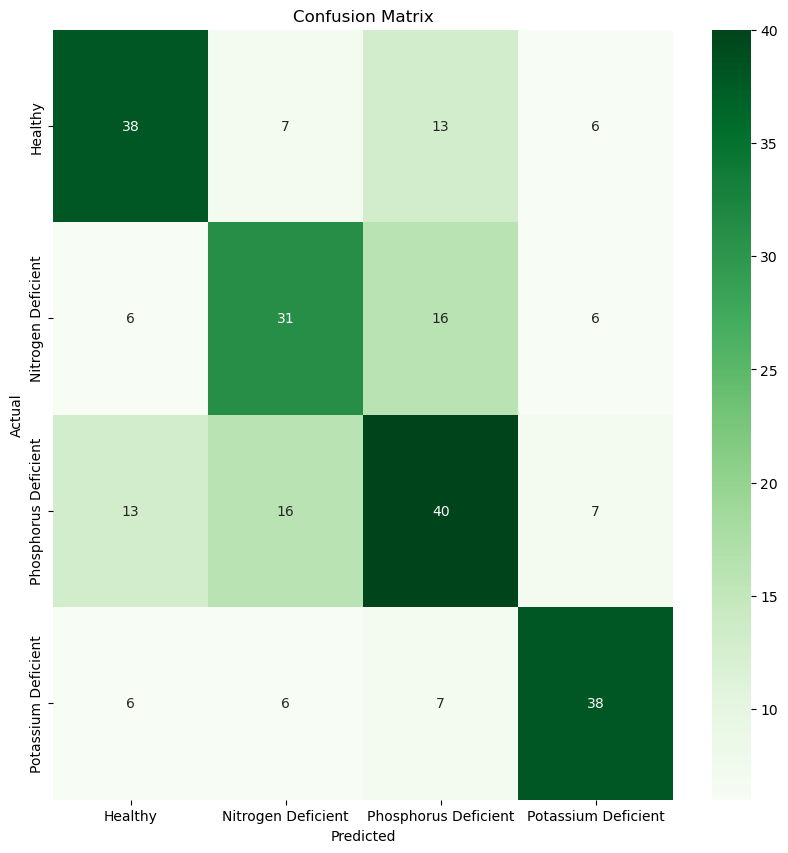

In [23]:
#Confusion Matrix
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#code to predict from a folder
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def preprocess_image(img_path, target_size=(299, 299)):
    # Load image with the correct size for the model
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict function
def predict_image(img_path):
    # Preprocess the image
    img = preprocess_image(img_path)
    
    # Predict the class
    predictions = resnet_model.predict(img)
    
    # Get the index of the highest probability class
    predicted_class = np.argmax(predictions[0])
    
    # Output the predicted class
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {np.max(predictions[0]) * 100:.2f}%")

    # Plot the image
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.show()
    # remove square grids

# Call the prediction function with your image
image_path = "C:/Users/REYES/OneDrive/Desktop/testing/1.jpg"
predict_image(image_path)


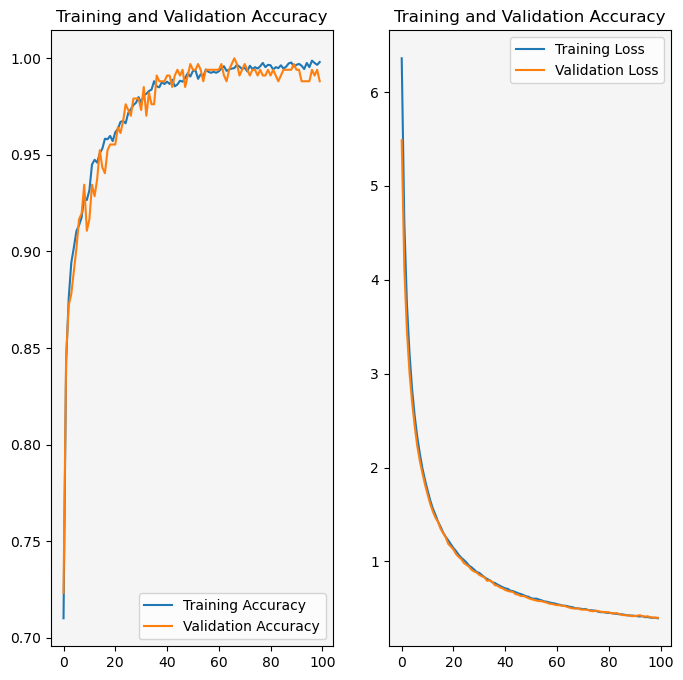

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [25]:
# Freeze all layers except the last 15 layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Unfreeze the last 15 layers
for layer in base_model.layers[-15:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                        

In [26]:
history_finetune = resnet_model.fit(
    train_ds,
    epochs=10,  # Additional epochs for fine-tuning
    batch_size = 64,
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/10
66/66 [==============================] - 40s 424ms/step - loss: 0.7803 - accuracy: 0.8774 - val_loss: 1.6445 - val_accuracy: 0.7857 - lr: 5.0000e-04
Epoch 2/10
66/66 [==============================] - 26s 397ms/step - loss: 0.5831 - accuracy: 0.9167 - val_loss: 0.6118 - val_accuracy: 0.9167 - lr: 5.0000e-04
Epoch 3/10
66/66 [==============================] - 26s 399ms/step - loss: 0.5255 - accuracy: 0.9409 - val_loss: 0.5457 - val_accuracy: 0.9196 - lr: 5.0000e-04
Epoch 4/10
66/66 [==============================] - 27s 406ms/step - loss: 0.4525 - accuracy: 0.9557 - val_loss: 0.4133 - val_accuracy: 0.9732 - lr: 5.0000e-04
Epoch 5/10
66/66 [==============================] - 26s 401ms/step - loss: 0.4282 - accuracy: 0.9603 - val_loss: 0.5737 - val_accuracy: 0.8988 - lr: 5.0000e-04
Epoch 6/10
66/66 [==============================] - 27s 405ms/step - loss: 0.3994 - accuracy: 0.9574 - val_loss: 0.3626 - val_accuracy: 0.9762 - lr: 5.0000e-04
Epoch 7/10
66/66 [======================

In [27]:
scores = resnet_model.evaluate(test_ds) #Fine-Tuning

#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history_finetune.history['accuracy']))
print("Highest Validation Accuracy: ", max(history_finetune.history['val_accuracy']))
print("Lowest Loss: ", min(history_finetune.history['loss']))
print("Lowest Validation Loss: ", min(history_finetune.history['val_loss']))
print("Final Accuracy: ", history_finetune.history['accuracy'][-1])
print("Final Validation Accuracy: ", history_finetune.history['val_accuracy'][-1])
print("Final Loss: ", history_finetune.history['loss'][-1])
print("Final Validation Loss: ", history_finetune.history['val_loss'][-1])

4/4 [==============================] - 2s 333ms/step - loss: 0.1879 - accuracy: 0.9922
Highest Accuracy:  0.9915212988853455
Highest Validation Accuracy:  0.9851190447807312
Lowest Loss:  0.2143169641494751
Lowest Validation Loss:  0.22188958525657654
Final Accuracy:  0.9915212988853455
Final Validation Accuracy:  0.9851190447807312
Final Loss:  0.2143169641494751
Final Validation Loss:  0.22188958525657654


In [30]:
#Metrics
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

4/4 [==============================] - 1s 400ms/step
F1 Score: 0.625071304563492
Precision: 0.6253015930724484
Recall: 0.625
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        64
           1       0.61      0.63      0.62        59
           2       0.68      0.68      0.68        76
           3       0.54      0.54      0.54        57

    accuracy                           0.62       256
   macro avg       0.62      0.62      0.62       256
weighted avg       0.63      0.62      0.63       256



4/4 [==============================] - 1s 454ms/step


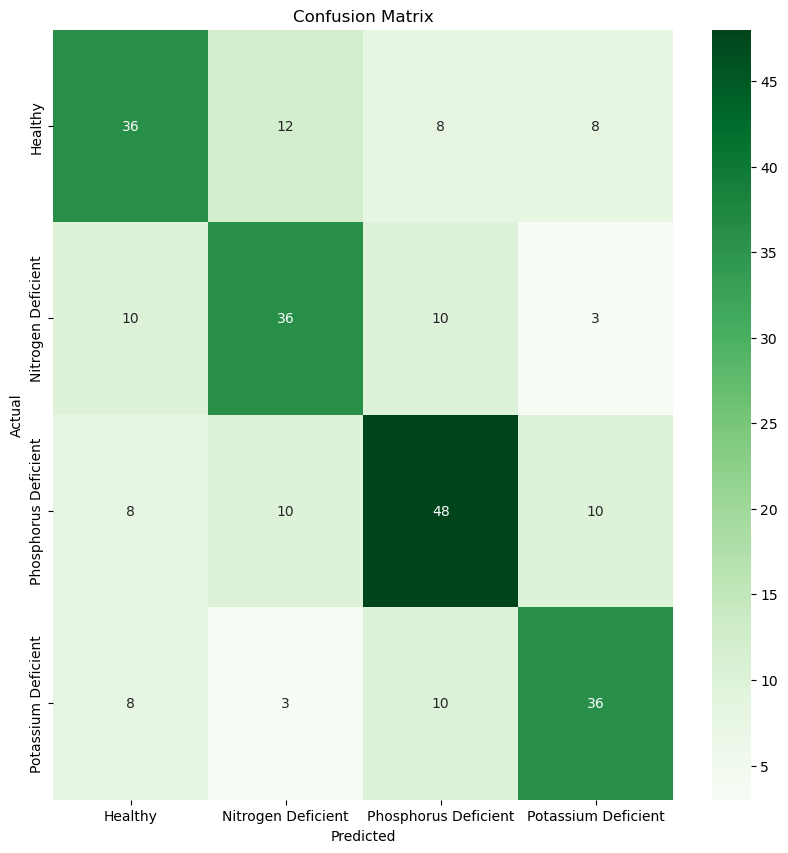

In [32]:
#Confusion Matrix
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

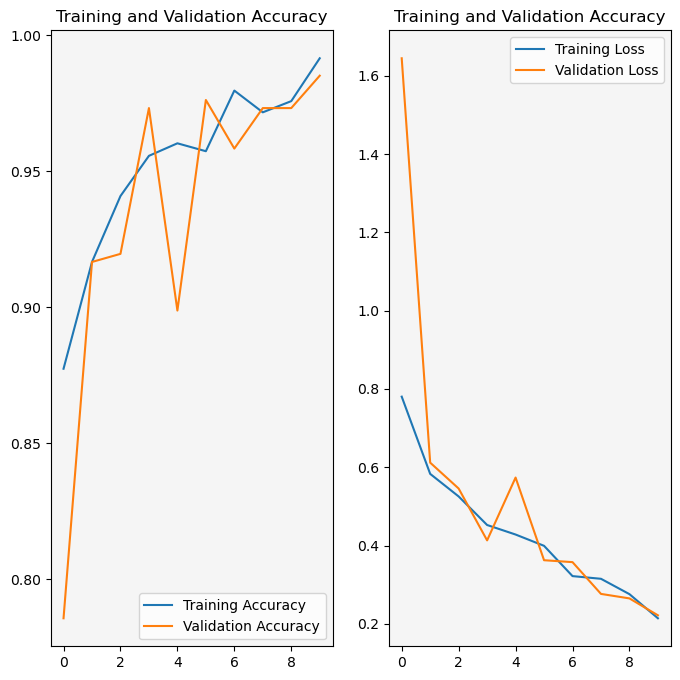

In [33]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
completed_epochs = len(history_finetune.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [ ]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
resnet_model.save(f"../models/{model_version}")

In [135]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


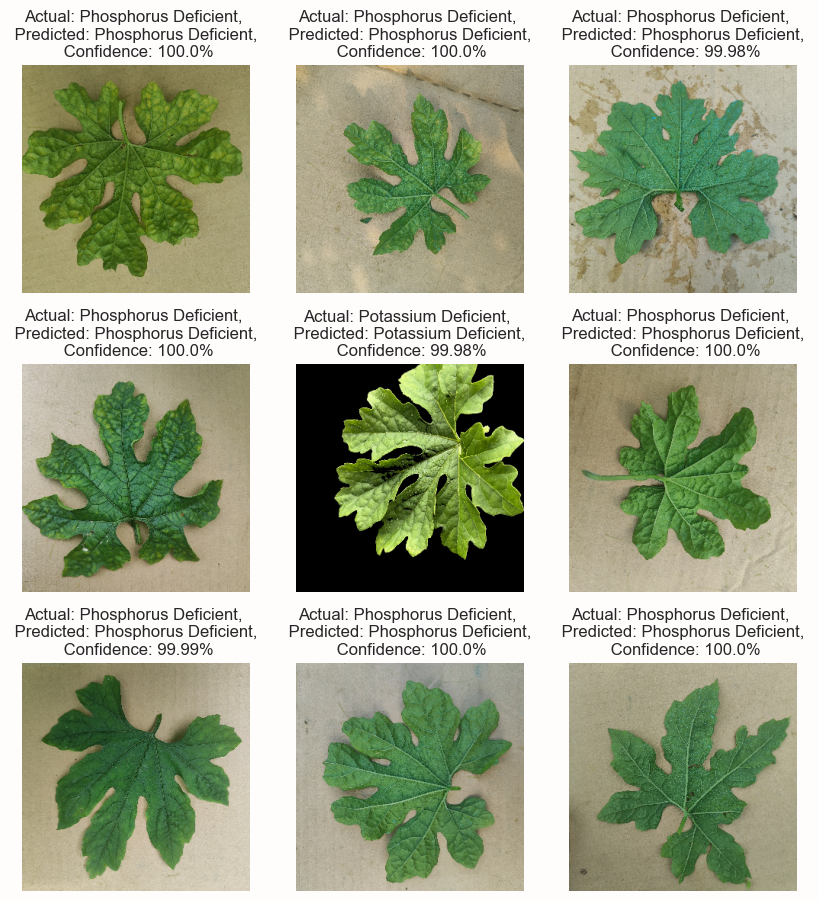

In [136]:
plt.figure(figsize=(10, 11))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")